## 基于 Embedding 与 RNN 进行文本分类

In [1]:
import tensorflow.keras as keras
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import os
import sys
import time
import tensorflow as tf

In [2]:
print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.3.0
sys.version_info(major=3, minor=7, micro=11, releaselevel='final', serial=0)
matplotlib 3.4.2
numpy 1.18.5
pandas 1.3.3
sklearn 1.0
tensorflow 2.3.0
tensorflow.keras 2.4.0


### 1. 数据集读取与词表构建

#### 1.1 读取数据

In [3]:
# imdb 是电影评论数据集, 类别为积极与消极
imdb = keras.datasets.imdb
# 词表数量, 前 10000 个会被保存, 其他的会被当做特殊字符处理
vocab_size = 10000
# 词表的index从index_from 开始算, 因为要设置特殊字符! 0 ~ 3 是特殊字符
index_from = 3

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=vocab_size, index_from=index_from)

In [4]:
# 打印向量
print(train_data[0], train_labels[0])
print(train_data.shape, train_labels.shape)
print(len(train_data[0]), len(train_data[1]))

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32] 1
(25000,) (25000,)
218 189


In [5]:
print(test_data.shape, test_labels.shape)

(25000,) (25000,)


#### 1.2 构建词表

In [6]:
# 获取词表， word_index = (单词, 索引)
word_index = imdb.get_word_index()
print(len(word_index))

88584


In [7]:
print(type(word_index))
# 打印前10个词表
for word, index in word_index.items():
    if int(index) < 30:
        print(word , index)

<class 'dict'>
with 16
one 28
have 25
i 10
he 26
as 14
it 9
is 6
in 8
but 18
on 20
of 4
his 24
all 29
this 11
not 21
you 22
a 3
for 15
be 27
br 7
the 1
was 13
and 2
to 5
film 19
movie 17
that 12
are 23


In [8]:
# 因为之前的设置 index_from = 3, 所以所有的索引都需要偏移3
word_index = {word : (index + 3) for word,index in word_index.items()}

In [9]:
# 设置特殊字符
# <PAD> padding 的填充字符
# <START> 句子的开头的填充字符
# <UNK> 找不到字符时, 返回UNK
# <END> 句子的末尾的特殊字符

word_index['<PAD>'] = 0
word_index['<START>'] = 1
word_index['<UNK>'] = 2
word_index['<END>'] = 3
reverse_word_index = dict([(index, word) for word, index in word_index.items()])

In [10]:
# 使用词表反向解析句子
def decode_review(text_ids):
    return " ".join(
        [reverse_word_index.get(word_id, "<UNK>") for word_id in text_ids]
    )
# 解析数字为真实文本
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

### 2. 数据padding

- padding 就是对数据进行变长处理
    1. 处理方式: 如果数据过长, 就截断数据, 如果数据过短就使用字符(0)填充
    2. 合并
- keras.preprocessing.sequence.pad_sequences
    1. value=word_index['<PAD>'] , 使用词表中 'PAD' 对应的部分进行填充
    2. padding='post' , value : post or pre , post 就是 把 padding 放到句子的后面, pre 就是 把padding 放到句子的前面
    3. maxlen=max_length 句子的最大长度

In [11]:
# 设置的单个句子的最长的长度

max_length = 500

# 对训练数据进行padding

train_data = keras.preprocessing.sequence.pad_sequences(
    train_data, # integer of list
    value=word_index['<PAD>'] , # 使用词表中 'PAD' 对应的部分进行填充
    padding='post' , # value : post or pre , post 就是 把 padding 放到句子的后面, pre 就是 把padding 放到句子的前面
    maxlen=max_length # 句子的最大长度
)

test_data = keras.preprocessing.sequence.pad_sequences(
    test_data, # integer of list
    value=word_index['<PAD>'] , # 使用词表中 'PAD' 对应的部分进行填充
    padding='post' , # value : post or pre , post 就是 把 padding 放到句子的后面, pre 就是 把padding 放到句子的前面
    maxlen=max_length # 句子的最大长度
)

# 打印样本
print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

### 3. 模型构建

In [12]:
# 每个word都转换成长度为 16 的向量
embedding_dim = 16
batch_size = 128

# 定义模型
single_rnn_model =  keras.models.Sequential([
    # 1. 定义一个 [vocab_size, embedding_dim] 的矩阵
    # 2. 注意 : train_data : [1, 14, 22, 16, 43, 530, 973, ... ] 类似于这样的索引, 1 . 14 这种的是词表中对应单词的索引
    # 3. embedding 对每一个单词生成一个长度为 embedding_dim(16) 的向量(是向量不是矩阵, 是一维的, 注意是每一个单词)
    # 4. 一个句子 train_data[i] 会生成一个 embedding_dim * max_length 的二位矩阵 [max_length, embedding_dim]
    # 5. 最终会生成一个 batch_size * max_length * embedding_dim 的 三维矩阵
    keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=max_length
    ),
    # 添加RNN层
    keras.layers.SimpleRNN(units=64, return_sequences=False),  # return_sequences : 决定返回的是最后一步的输出(False)还是所有的输出(True)
    # 添加全连接层
    keras.layers.Dense(64, activation="relu"),
    # 输出分类结果
    keras.layers.Dense(1, activation="softmax")
])

single_rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 16)           160000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 64)                5184      
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 169,409
Trainable params: 169,409
Non-trainable params: 0
_________________________________________________________________


- Adam Optimizer是对SGD的扩展，可以代替经典的随机梯度下降法来更有效地更新网络权重
    1. 计算效率高
    2. 很少的内存需求
    3. 梯度的对角线重缩放不变（这意味着亚当将梯度乘以仅带正因子的对角矩阵是不变的，以便更好地理解此堆栈交换）
    4. 非常适合数据和/或参数较大的问题
    5. 适用于非固定目标
    6. 适用于非常嘈杂和/或稀疏梯度的问题
    7. 超参数具有直观的解释，通常需要很少的调整（我们将在配置部分中对此进行详细介绍）

- binary_crossentropy : 二进制交叉熵
    1. 参考 : https://blog.csdn.net/qq_35599937/article/details/105608354

In [13]:
single_rnn_model.compile(optimizer='adam', loss="binary_crossentropy", metrics=['accuracy'])

In [14]:
history = single_rnn_model.fit(
    train_data, train_labels,epochs=30, batch_size=batch_size,
    validation_split=0.2  # 设置验证集为 20% 
)

Epoch 1/30
157/157 [==============================] - 26s 164ms/step - loss: 7.6010 - accuracy: 0.5016 - val_loss: 7.7192 - val_accuracy: 0.4938

In [15]:
history.history

{'loss': [7.600982666015625,
  7.600982189178467,
  7.600984573364258,
  7.600983619689941,
  7.600985050201416,
  7.600985050201416,
  7.600982666015625,
  7.600983619689941,
  7.600983619689941,
  7.600984573364258,
  7.600984573364258,
  7.600984573364258,
  7.600980281829834,
  7.600980281829834,
  7.600983619689941,
  7.600982666015625,
  7.600982666015625,
  7.600983619689941,
  7.600982666015625,
  7.600982666015625,
  7.600980281829834,
  7.600982666015625,
  7.600984573364258,
  7.600983619689941,
  7.600985050201416,
  7.600984573364258,
  7.600985050201416,
  7.600982189178467,
  7.60098123550415,
  7.600985050201416],
 'accuracy': [0.501550018787384,
  0.501550018787384,
  0.501550018787384,
  0.501550018787384,
  0.501550018787384,
  0.501550018787384,
  0.501550018787384,
  0.501550018787384,
  0.501550018787384,
  0.501550018787384,
  0.501550018787384,
  0.501550018787384,
  0.501550018787384,
  0.501550018787384,
  0.501550018787384,
  0.501550018787384,
  0.5015500187

### 4. 绘制图像

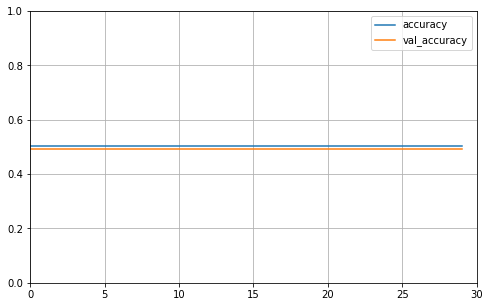

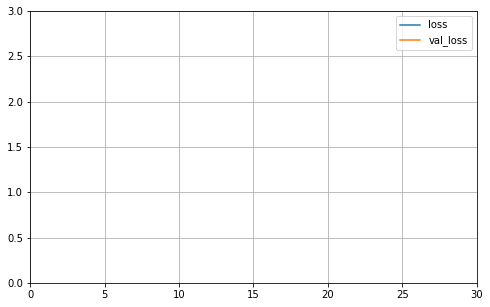

In [19]:
def plot_learning_curves(history, label, epochs, min_value, max_value):
    data = {}
    data[label] = history.history[label]
    data["val_" + label] = history.history["val_" + label]
    pd.DataFrame(data).plot(figsize=(8,5))
    plt.grid(True)
    plt.axis([0, epochs, min_value, max_value])
    plt.show()

# val_accuracy : 验证集的准确率
# val_loss : 验证集的误差
# 如下图可以看到, 验证集上的loss一段平稳过后直线上升, 说明出现了过拟合
plot_learning_curves(history, 'accuracy', 30, 0, 1)
plot_learning_curves(history, 'loss', 30, 0, 3)

In [18]:
# 使用测试集进行验证
single_rnn_model.evaluate(test_data, test_labels, batch_size=batch_size)

196/196 [==============================] - 10s 53ms/step - loss: 7.6246 - accuracy: 0.5000

[7.6246185302734375, 0.5]